# Model inference on open-source data

This notebook is a simple example of how to load a trained model and make predictions on a publicly available dataset. The model we're working with was trained using the scripts in notebook [4_backward_model_training.ipynb](4_backward_model_training.ipynb).

## Load and convert data
For the purpose of inference example we use a sample of 100 spectra from the [SWGDRUG](https://www.swgdrug.org/ms.htm) library that we converted to the standard `.msp` format and annotated with SMILES using the [MSMetaEnhancer](https://github.com/RECETOX/MSMetaEnhancer) tool. The sample is available in our repository `ROOT/data/example/SWGDRUG_100.msp`, more on the data annotation process [here](extra_libraries_annotation.ipynb).

In [4]:
import sys
sys.path.append('..')
from pathlib import Path
from spectus.utils.spectra_process_utils import msp2jsonl

In [ ]:
DATA_PATH_MSP = "../data/example/SWGDRUG_100.msp"

msp2jsonl(Path(DATA_PATH_MSP), smiles_field_name="canonical_smiles")

100%|██████████| 106/106 [00:00<00:00, 4128.94it/s]

Couldn't be canonicalized due to Exception: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type NoneType
Couldn't be canonicalized due to Exception: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type NoneType
Couldn't be canonicalized due to Exception: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type NoneType
Couldn't be canonicalized due to Exception: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type NoneType
Couldn't be canonicalized due to Exception: No registered converter was able to 

## Generate predictions

Now we have the example dataset prepared the same way as all our training and evaluation splits and can continue to predicting molecules from spectra.

To generate predictions we need to specify a configuration file and a path to the trained model. The configuration file for MACE dataset is provided in the `config` directory as [predict_examlpe.yaml](../configs/predict_example.yaml). 

The script [predict.py](../spectus/predict.py) is used to generate predictions. It takes a `jsonl` file with `mz` and `intensity` fields as inputs. It outputs a `jsonl` file where each line is a `json` with keys being the generated SMILES strings and their values are candidates' probabilities generated by our model. We use these probabilities to sort candidates.

Statistics and all metadata about the run are stored in `log_file.yaml` in the same directory as the predictions.

Running `predict.py` could look like this:

```bash
cd ROOT
CUDA_VISIBLE_DEVICES=0 python spectus/predict.py --checkpoint "checkpoints/finetune_clean/youthful-wave-590_exp5_9M_448+296/checkpoint-294952" \
                                                 --output-folder predictions \
                                                 --config-file configs/predict_example.yaml
```

## Evaluate predictions
Evaluation of predictions is done with the [evaluate_predictions.py](spectus/evaluate_predictions.py) script. It takes a path to the predictions file, a path to the ground truth file and a path to a [config file](../configs/evaluate.yaml) as input and appends all the evaluation metrics to the corresponding `log_file.yaml`. The script also generates several plots and saves them in the same directory as the predictions.

**Note**: Be aware of filtering mechanism in the datapipeline - we use both m/z values and SMILES strings for filtering and perform filtering during both generation and evaluation stages. If you have your spectra and labels in two separate files you easily end up with different lengths of predictions-labels lists or paired predictions with wrong labels. Also be sure to have the same filtering criteria specified in config files during prediction and evaluation. **In other words**: have your labels ("smiles") and spectra ("mz", "intensity") in the same file when evaluating a test file. Also check the values of `max_num_peaks`, `max_mz`, `max_mol_repr_len` and `mol_repr` in the config files. They should be the same for both prediction and evaluation.

Running `evaluate_predictions.py` could look like this:

```bash
cd ROOT
python spectus/evaluate_predictions.py --predictions-path predictions/youthful-wave-590_exp5_9M_448+296/SWGDRUG_100/1738607067_all_full_beam10/predictions.jsonl \
                               --config-file configs/evaluate.yaml
```

-----------------------------------------------
# Playground
## Visualize predictions
To see what the model's predictions look like we prepared a little visualization script.

In [8]:
import json
from rdkit import Chem, DataStructs
from utils.eval_utils import load_labels_to_datapipe

# load labels and predictions
predictions_path = "../predictions/youthful-wave-590_exp5_9M_448+296/SWGDRUG_100/1738607067_all_full_beam10/predictions.jsonl"
labels_path = Path(DATA_PATH_MSP).with_suffix(".jsonl")


labels, _ = load_labels_to_datapipe(Path(labels_path))
labels = list(labels)
str_predictions = open(predictions_path).readlines()
dict_predictions = [json.loads(p) for p in str_predictions]
sorted_predictions = [sorted([k for k, _ in sorted(pred.items(), key=lambda x: x[1])]) for pred in dict_predictions]


/home/xhajek9/miniconda3/envs/trainSpectus/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:137: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(



##################
GT smiles: CC(O)c1ccc2c(c1)OCO2


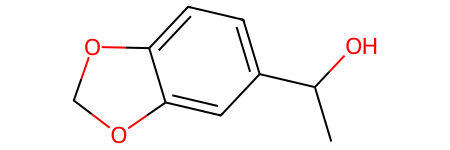

Prediction 0: CC(O)(O)c1ccc2c(c1)OCO2, similarity: 0.9028132992327366


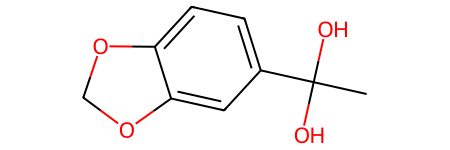

Prediction 1: CC(O)Oc1ccc2c(c1)OCO2, similarity: 0.3577981651376147


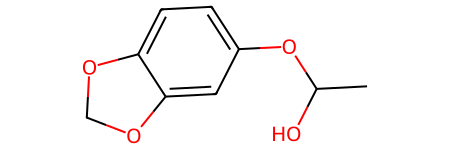

Prediction 2: CC(O)[Si](C)(C)c1ccc2c(c1)OCO2, similarity: 0.28711256117455136


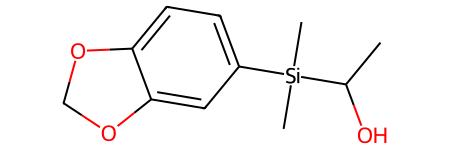

Prediction 3: CC(O)c1ccc2c(c1)OCO2, similarity: 1.0


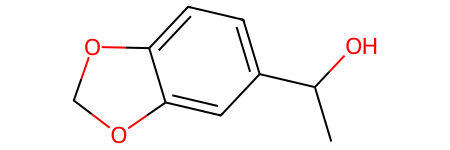

Prediction 4: CC(O)c1ccc2c(c1)OCO2.Cl, similarity: 1.0


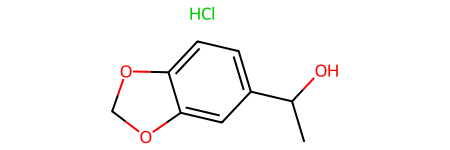

In [11]:
pairs_to_viz = list(zip(labels, sorted_predictions))[81]  # TODO: change this to visualize different pairs
best_n_to_viz = 5                                         # TODO: change this to visualize more/less predictions

if isinstance(pairs_to_viz, tuple):
    pairs_to_viz = [pairs_to_viz]

for gt_smiles, preds in pairs_to_viz:
    print("\n##################")
    print("GT smiles:", gt_smiles)
    gt_mol = Chem.MolFromSmiles(gt_smiles)
    display(gt_mol)
    for i, pred_smiles in enumerate(preds[:best_n_to_viz]):
        pred_mol = Chem.MolFromSmiles(pred_smiles)
        print(f"Prediction {i}: {pred_smiles}, similarity: {DataStructs.FingerprintSimilarity(Chem.RDKFingerprint(gt_mol), Chem.RDKFingerprint(pred_mol))}")
        display(pred_mol)